In [ ]:
pip install scikit-plot

In [ ]:
from numpy import array, save, asarray
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense, Dropout, GRU
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
import pickle
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import scikitplot as skplt

Split a univariate sequence into samples

In [ ]:
def split_sequence(sequence, n_steps, classes):
    X, y = [], []
    for i in range(0, len(sequence), n_steps):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = array(classes[i:end_ix])
        if np.sum(seq_y)==0:
            seq_y = 0; # normal
        else:
            seq_y = seq_y[seq_y>0]                 # ignore normal events 
            seq_y = np.argmax (np.bincount(seq_y)) # select most frequent attack
        X.append(seq_x)
        y.append(seq_y) 
    return array(X), array(y)

Load training data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
F  = pd.read_csv('/content/drive/My Drive/GrupoEstudiantesAgo-Dic2020/IDS/DataSets/CICDoS2017/Pre-processed/dataTrain.csv')
xtrainlabel = F.loc[:,['Label']].values

xtrain = F.loc[:, ['Flow.Duration', 'Tot.Fwd.Pkts', 'Tot.Bwd.Pkts', 'TotLen.Fwd.Pkts',
       'TotLen.Bwd.Pkts', 'Fwd.Pkt.Len.Max', 'Fwd.Pkt.Len.Min',
       'Fwd.Pkt.Len.Std', 'Bwd.Pkt.Len.Max', 'Bwd.Pkt.Len.Min',
       'Bwd.Pkt.Len.Std', 'Flow.Byts.s', 'Flow.Pkts.s', 'Flow.IAT.Mean',
       'Flow.IAT.Std', 'Flow.IAT.Max', 'Flow.IAT.Min', 'Fwd.IAT.Mean',
       'Fwd.IAT.Std', 'Fwd.IAT.Min', 'Bwd.IAT.Tot', 'Bwd.IAT.Mean',
       'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags',
       'Fwd.Pkts.s', 'Bwd.Pkts.s', 'Pkt.Len.Min', 'Pkt.Len.Max',
       'Pkt.Len.Mean', 'Pkt.Len.Std', 'Pkt.Len.Var', 'FIN.Flag.Cnt',
       'SYN.Flag.Cnt', 'RST.Flag.Cnt', 'PSH.Flag.Cnt', 'Down.Up.Ratio',
       'Bwd.Pkts.b.Avg', 'Bwd.Blk.Rate.Avg', 'Subflow.Fwd.Pkts',
       'Subflow.Fwd.Byts', 'Subflow.Bwd.Byts', 'Init.Fwd.Win.Byts',
       'Init.Bwd.Win.Byts', 'Fwd.Seg.Size.Min', 'Idle.Mean', 'Idle.Std',
       'Idle.Min']].values
xtrainlabel = F['Label'].values.tolist() # Label

In [ ]:
print('xtrainshape',xtrain.shape)
print('trainLabel=',xtrainlabel)

xtrainshape (102692, 49)
trainLabel= [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Principal components on Training data

In [ ]:
rotation= pd.read_csv('/content/drive/MyDrive/GrupoEstudiantesAgo-Dic2020/IDS/DataSets/CICDoS2017/Pre-processed/rotation.csv')
center  = pd.read_csv('/content/drive/MyDrive/GrupoEstudiantesAgo-Dic2020/IDS/DataSets/CICDoS2017/Pre-processed/center.csv')
scale   = pd.read_csv('/content/drive/MyDrive/GrupoEstudiantesAgo-Dic2020/IDS/DataSets/CICDoS2017/Pre-processed/scale.csv')
center  = array(center['center'].values.tolist())
scale   = array(scale['scale'].values.tolist())
rotation.drop('Unnamed: 0',axis='columns', inplace=True)
rotation= array(rotation.values.tolist())
pca = np.delete(rotation,[[i for i in range(15,len(rotation))]],1)
print('pca.shape',pca.shape)
xxtrain = []
for i in range(len(xtrain)):
    xn = (xtrain[i]-center)/scale
    xpca = (np.resize(xn,(1,len(xn)))).dot(pca) 
    xxtrain.append(xpca) 
x_train = array(xxtrain) 
x_train = (np.resize(x_train,(len(x_train),15))) # 15 for DoS2017, 16 for DDoS2019
print('xtrainshape',x_train.shape)


pca.shape (49, 15)
xtrainshape (55873, 15)


Set number of features

In [ ]:
# set number of features
n_features = x_train.shape[1]
# set number of time steps
n_steps = 3     #  DoS2017
# split into [samples, timesteps, features]
X_train, Y_train = split_sequence(x_train, n_steps, xtrainlabel)


In [ ]:
print(X_train.shape)
print(Y_train.shape)


(18624, 3, 15)
(18624,)


**TRAINING MODEL**

In [ ]:
# define parameters
batch_size = 250 # samples per stack 250 DoS2017
kernel_size= 3   # 3 DoS2017
epochs = 50      # 50 DoS2017
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))  
model.add(Dropout(0.25)) 
model.add(Dense(40, activation='relu'))  
model.add(Dense(25, activation='relu'))
model.add(Dense(9,activation='softmax')) # 9 for DDoS2017
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
model.fit(X_train, Y_train, batch_size, epochs=epochs)

Epoch 1/50
137/137 [==============================] - 4s 11ms/step - loss: 1.4005 - sparse_categorical_accuracy: 0.7150
Epoch 2/50
137/137 [==============================] - 2s 12ms/step - loss: 0.2975 - sparse_categorical_accuracy: 0.9052
Epoch 3/50
137/137 [==============================] - 2s 11ms/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9369
Epoch 4/50
137/137 [==============================] - 2s 11ms/step - loss: 0.1385 - sparse_categorical_accuracy: 0.9525
Epoch 5/50
137/137 [==============================] - 1s 11ms/step - loss: 0.1115 - sparse_categorical_accuracy: 0.9630
Epoch 6/50
137/137 [==============================] - 1s 11ms/step - loss: 0.0903 - sparse_categorical_accuracy: 0.9682
Epoch 7/50
137/137 [==============================] - 2s 11ms/step - loss: 0.0861 - sparse_categorical_accuracy: 0.9698
Epoch 8/50
137/137 [==============================] - 2s 11ms/step - loss: 0.0767 - sparse_categorical_accuracy: 0.9726
Epoch 9/50
137/137 [====================

In [ ]:
!pip install scikit-plot

Verify fitting on training

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
yhat = model.predict(X_train)
yyhat = []
for k in range (0,len(yhat)):
    yh = np.argmax(yhat[k]) # max probability
    yyhat.append(yh)
accuracy = metrics.accuracy_score(Y_train, yyhat)
print(accuracy)
# precision recall and fscore
precision_recall_fscore_support(Y_train, yyhat, average='weighted')

0.991995325737657


(0.9923509080085049, 0.991995325737657, 0.9920314910862558, None)

In [ ]:
model = load_model('/content/drive/MyDrive/GrupoEstudiantesAgo-Dic2020/IDS/Aplicaciones/Modelling/Best Model Objects/CICDoS2017/ltsm/LSTM')

In [ ]:
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 3, 50)             13200     
_________________________________________________________________
lstm_63 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_40 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 40)                2040      
_________________________________________________________________
dense_80 (Dense)             (None, 25)                1025      
_________________________________________________________________
dense_81 (Dense)             (None, 9)                 234       
Total params: 36,699
Trainable params: 36,699
Non-trainable params: 0
_________________________________________________

Load testing data

In [ ]:
F  = pd.read_csv('/content/drive/My Drive/GrupoEstudiantesAgo-Dic2020/IDS/DataSets/CICDoS2017/Pre-processed/dataTest.csv')
xtestlabel = F.loc[:,['Label']].values
xtest = F.loc[:, ['Flow.Duration', 'Tot.Fwd.Pkts', 'Tot.Bwd.Pkts', 'TotLen.Fwd.Pkts',
       'TotLen.Bwd.Pkts', 'Fwd.Pkt.Len.Max', 'Fwd.Pkt.Len.Min',
       'Fwd.Pkt.Len.Std', 'Bwd.Pkt.Len.Max', 'Bwd.Pkt.Len.Min',
       'Bwd.Pkt.Len.Std', 'Flow.Byts.s', 'Flow.Pkts.s', 'Flow.IAT.Mean',
       'Flow.IAT.Std', 'Flow.IAT.Max', 'Flow.IAT.Min', 'Fwd.IAT.Mean',
       'Fwd.IAT.Std', 'Fwd.IAT.Min', 'Bwd.IAT.Tot', 'Bwd.IAT.Mean',
       'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags',
       'Fwd.Pkts.s', 'Bwd.Pkts.s', 'Pkt.Len.Min', 'Pkt.Len.Max',
       'Pkt.Len.Mean', 'Pkt.Len.Std', 'Pkt.Len.Var', 'FIN.Flag.Cnt',
       'SYN.Flag.Cnt', 'RST.Flag.Cnt', 'PSH.Flag.Cnt', 'Down.Up.Ratio',
       'Bwd.Pkts.b.Avg', 'Bwd.Blk.Rate.Avg', 'Subflow.Fwd.Pkts',
       'Subflow.Fwd.Byts', 'Subflow.Bwd.Byts', 'Init.Fwd.Win.Byts',
       'Init.Bwd.Win.Byts', 'Fwd.Seg.Size.Min', 'Idle.Mean', 'Idle.Std',
       'Idle.Min']].values
print(xtest)
xtrainlabel = F['Label'].values.tolist() # Label

print('xtestshape',xtest.shape)
print('xtestLabelshape',xtestlabel.shape)



Index(['Flow.Duration', 'Tot.Fwd.Pkts', 'Tot.Bwd.Pkts', 'TotLen.Fwd.Pkts',
       'TotLen.Bwd.Pkts', 'Fwd.Pkt.Len.Max', 'Fwd.Pkt.Len.Min',
       'Fwd.Pkt.Len.Std', 'Bwd.Pkt.Len.Max', 'Bwd.Pkt.Len.Min',
       'Bwd.Pkt.Len.Std', 'Flow.Byts.s', 'Flow.Pkts.s', 'Flow.IAT.Mean',
       'Flow.IAT.Std', 'Flow.IAT.Max', 'Flow.IAT.Min', 'Fwd.IAT.Mean',
       'Fwd.IAT.Std', 'Fwd.IAT.Min', 'Bwd.IAT.Tot', 'Bwd.IAT.Mean',
       'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags',
       'Fwd.Pkts.s', 'Bwd.Pkts.s', 'Pkt.Len.Min', 'Pkt.Len.Max',
       'Pkt.Len.Mean', 'Pkt.Len.Std', 'Pkt.Len.Var', 'FIN.Flag.Cnt',
       'SYN.Flag.Cnt', 'RST.Flag.Cnt', 'PSH.Flag.Cnt', 'Down.Up.Ratio',
       'Bwd.Pkts.b.Avg', 'Bwd.Blk.Rate.Avg', 'Subflow.Fwd.Pkts',
       'Subflow.Fwd.Byts', 'Subflow.Bwd.Byts', 'Init.Fwd.Win.Byts',
       'Init.Bwd.Win.Byts', 'Fwd.Seg.Size.Min', 'Idle.Mean', 'Idle.Std',
       'Idle.Min'],
      dtype='object')
xtestshape (49,)
xtestLabelshape (55873, 1)


Principal components on testing data

In [ ]:
print('pca.shape',pca.shape)
xxtest = []
for i in range(len(xtest)):
    xn = (xtest[i]-center)/scale
    xpca = (np.resize(xn,(1,len(xn)))).dot(pca) 
    xxtest.append(xpca) 
x_test = array(xxtest) 
x_test = (np.resize(x_test,(len(x_test),15))) # 15 for DoS2017, 16 for DDoS2019
print('xtestshape',x_test.shape)



pca.shape (49, 15)
xtestshape (55873, 15)


Data split

In [ ]:
# split into [samples, timesteps, features]
X_test, Y_test = split_sequence(x_test, n_steps, xtestlabel)
print(X_test.shape)
print(Y_test.shape)

(18624, 3, 15)
(18624,)


Test model on new data 

***************************************************************
EVALUATE MODEL ON TESTING DATA
582/582 [==============================] - 1s 2ms/step - loss: 0.1055 - sparse_categorical_accuracy: 0.9832
***************************************************************
Assessment: 2 classes
Accuracy 0.9947379725085911
Precision 0.9947423276548041
F1-SCORE 0.9947397756681569
RECALL (TPR) 0.9947379725085911
FALSE POS. RATE (FPR) 0.003898635477582846
***************************************************************
Assessment: n classes
Accuracy 0.9831937285223368
Precision 0.9835725013811979
F1-SCORE 0.9829291466267587
RECALL (TPR) 0.9831937285223368


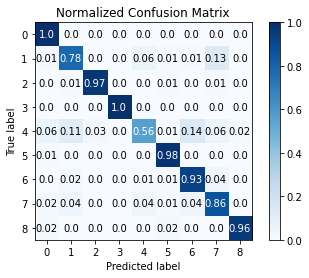

In [ ]:
from sklearn.metrics import accuracy_score, recall_score,f1_score,precision_score,roc_auc_score

print("***************************************************************")
print("EVALUATE MODEL ON TESTING DATA")
results = model.evaluate(X_test, Y_test)
yhat = model.predict(X_test)
yyhat = []
for k in range (0,len(yhat)):
    yh = np.argmax(yhat[k])
    yyhat.append(yh)
print("***************************************************************")    
print("Assessment: 2 classes") 
TP=TN=FP=FN=0
y_test2c = np.array(Y_test)
y_test2c [y_test2c>=1] = 1;
y_hat2c = np.array(yyhat)
y_hat2c [y_hat2c>=1] = 1;
print("Accuracy", accuracy_score(y_test2c, y_hat2c))
print("Precision", precision_score(y_test2c, y_hat2c, average='weighted'))
print("F1-SCORE", f1_score(y_test2c, y_hat2c, average='weighted'))
print("RECALL (TPR)", recall_score(y_test2c, y_hat2c, average='weighted'))
 
for k in range (0,len(yhat)):
    ylabel     = Y_test[k];
    ypredicted = yyhat[k];
    if ypredicted == 0 and ylabel == 0:
        TN = TN + 1
    elif ypredicted > 0 and ylabel > 0:
        TP = TP + 1
    elif ypredicted > 0 and ylabel == 0:
        FP = FP + 1
    elif ypredicted == 0 and ylabel > 0:
        FN = FN + 1
    else:
        print('any')
# print("ACCURACY", (TP+TN)/(TP+TN+FP+FN))
# print("Precision ", (TP)/(TP+FP))
# print("F1-SCORE", (2*TP)/(2*TP+FP+FN))
# print("RECALL (TPR)", (TP)/(TP+FN))
print("FALSE POS. RATE (FPR)", (FP)/(FP+TN))


print("***************************************************************") 
print("Assessment: n classes") 
print("Accuracy", accuracy_score(Y_test, yyhat))
print("Precision", precision_score(Y_test, yyhat, average='weighted'))
print("F1-SCORE", f1_score(Y_test, yyhat, average='weighted'))
print("RECALL (TPR)", recall_score(Y_test, yyhat, average='weighted'))


skplt.metrics.plot_confusion_matrix(Y_test,yyhat,normalize="True")

# Time complexity Analysis



In [ ]:
import timeit

def prediction():
  yhat = model.predict(X_test[0:10000]);

# load model and testing data

execution_time = timeit.repeat(prediction, number=1, repeat=100)
print('Average Flow/s: ', 1/((min(execution_time))/10000))



Average Flow/s:  19598.96346178093


In [ ]:
y = X_test[0:10000]
y.shape

(10000, 3, 15)